In [ ]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
#from pandas import read_csv, set_option
from pandas import Series, datetime
from pandas.tools.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [3]:
eur_usd = pd.read_csv('./data/EUR_USD_exchange_rate.csv', index_col='Time', parse_dates=['Time'])
eur_usd.head()

,Open,High,Low,Close,Volume
Time,,,,,
2010-01-01 00:00:00,1.43283,1.43293,1.43224,1.43293,608600007.1
2010-01-01 00:15:00,1.43285,1.43295,1.43229,1.43275,535600003.2
2010-01-01 00:30:00,1.43280,1.43303,1.43239,1.43281,436299999.2
2010-01-01 00:45:00,1.43285,1.43294,1.43229,1.43276,614299997.3
2010-01-01 01:00:00,1.43287,1.43292,1.43206,1.43282,705300008.8


In [4]:
print(eur_usd.shape)
print(eur_usd.dtypes)

(245444, 5)
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


In [5]:
print(eur_usd.describe())

                Open           High            Low          Close  \
count  245444.000000  245444.000000  245444.000000  245444.000000   
mean        1.268372       1.268738       1.268003       1.268371   
std         0.112994       0.113017       0.112965       0.112994   
min         1.035580       1.036280       1.035230       1.035600   
25%         1.135350       1.135660       1.134870       1.135348   
50%         1.302350       1.302740       1.302100       1.302350   
75%         1.356560       1.356980       1.356082       1.356552   
max         1.493230       1.493980       1.491850       1.493240   

             Volume  
count  2.454440e+05  
mean   1.624311e+09  
std    2.320694e+09  
min    0.000000e+00  
25%    0.000000e+00  
50%    9.801100e+08  
75%    2.316977e+09  
max    3.779797e+10  


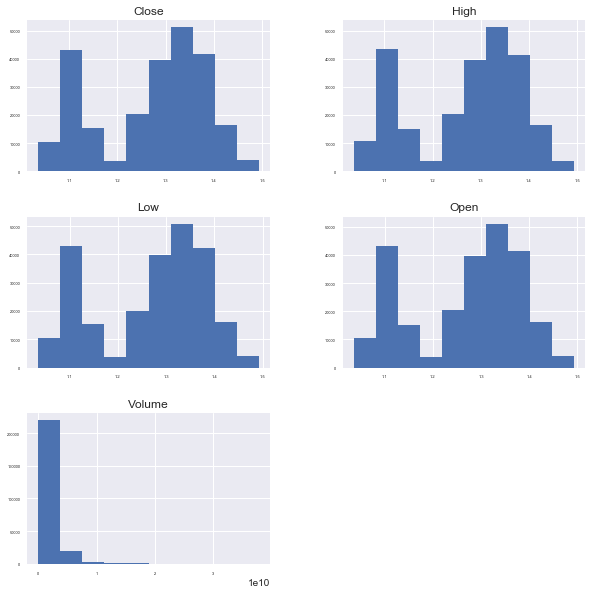

In [6]:
sns.set()
eur_usd.hist(sharex=False, sharey=False, xlabelsize=4, ylabelsize=4, figsize=(10,10))
pyplot.show()

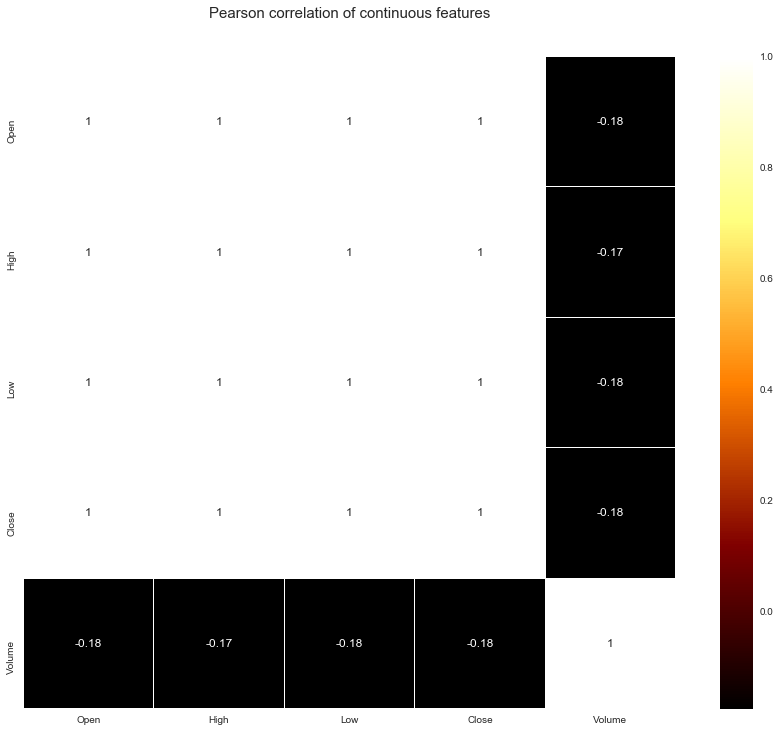

In [7]:
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(eur_usd.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

In [19]:
training = eur_usd[:'2015']
to_predict = eur_usd['2016']

In [45]:
# 96 rows per day
# 2 day simple moving average == SMA2
Predictors = pd.DataFrame({"sma2":eur_usd.Open.rolling(window=2).mean()})

Predictors["sma2_1"] = Predictors.sma2.shift(1)

Predictors["sma2_increment"] = Predictors.sma2.diff()  
 
Predictors["sma2_1_increment"] = Predictors.sma2_1.diff()  
 
Predictors["vol_increment"] = eur_usd.Volume.diff()
 
Predictors["vol_rel_increment"] = eur_usd.Volume.diff() / eur_usd.Volume
 
Predictors["open_1"] = eur_usd.Open.shift(1)
 
Predictors["open_incr"] = eur_usd.Open - eur_usd.Open.shift(1)
 
Predictors["open"] = eur_usd.Open
 
# The rows with nulls generated by rolling values will be removed.
Predictors = Predictors.dropna()

In [47]:
Predictors.head()


,sma2,sma2_1,sma2_increment,sma2_1_increment,vol_increment,vol_rel_increment,open_1,open_incr,open
Time,,,,,,,,,
2010-01-01 00:45:00,1.432825,1.432825,0.000000,-0.000015,177999998.1,0.289761,1.43280,0.00005,1.43285
2010-01-01 01:00:00,1.432860,1.432825,0.000035,0.000000,91000011.5,0.129023,1.43285,0.00002,1.43287
2010-01-01 01:15:00,1.432885,1.432860,0.000025,0.000035,-278000002.9,-0.650597,1.43287,0.00003,1.43290
2010-01-01 01:30:00,1.432785,1.432885,-0.000100,0.000025,-28100005.1,-0.070391,1.43290,-0.00023,1.43267
2010-01-01 01:45:00,1.432735,1.432785,-0.000050,-0.000100,82000007.6,0.170407,1.43267,0.00013,1.43280


In [48]:
target = pd.DataFrame({"value":Predictors.sma2.shift(-1) - Predictors.sma2}).dropna()

In [49]:
X = pd.merge(Predictors, target,left_index=True,right_index=True)[Predictors.columns]
y = pd.merge(Predictors, target,left_index=True,right_index=True)[target.columns]

In [50]:
train_samples = int(X.shape[0] * 0.65)
 
X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]
 
y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

In [52]:
def getBinary(val):
    if val>0:
        return 1
    else:
        return 0

y_test_binary = pd.DataFrame(y_test["value"].apply(getBinary))

In [55]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.01)
 
xgbModel = regressor.fit(X_train,y_train.value.apply(getBinary))
 
y_predicted = xgbModel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]
 
print (accuracy_score(y_test_binary,y_predicted_binary))

0.7394191548376571
